In [8]:
## MVTEC-AD 
%pip install tqdm
%pip install tensorflow
%pip install scikit-image
%pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 9.7 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf  
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from skimage import io
from skimage.transform import resize

import numpy as np

from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import cv2

import random
import os
from tqdm import tqdm

from random import randrange

2023-07-17 04:39:20.426465: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-17 04:39:20.481125: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-17 04:39:20.812466: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-17 04:39:20.814128: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 04:39:21.855906: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [4]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, path = "./content/mvtec_anomaly_detection/screw/",
                 batch_size = 4,
                 input_size=(224, 224),
                 shuffle=True, seed = None, subset = 'training'):
        
        self.image_data_generator = ImageDataGenerator(rescale=1. / 255, data_format='channels_last',     
            #zoom_range = 0.1,
            #width_shift_range = 0.05,
            #height_shift_range = 0.05,
            #brightness_range=(0.95,1.05)
        )
        
        if seed is None:
            random.randint(0, 2**32)
            
        self.batch_size = batch_size
        self.input_size = input_size
        
        self.X_paths = [os.fsdecode(file) for file in os.scandir(f"{path}/train/good")]
        self.X_train, self.X_val = train_test_split(self.X_paths, test_size=0.2, random_state = seed, shuffle = True)
        
        if subset == 'training':            
            self.X = self.X_train
        elif subset == 'validation':
            self.X = self.X_val
            
        self.n = len(self.X)
    
    
    def __getitem__(self, index):
        
        data_x = []
        
        for i in range(self.batch_size):
            image = cv2.imread(self.X[self.batch_size * index + i])
            
            image = self.image_data_generator.random_transform(image)
            
            image = image / 255
            
            image = tf.image.resize(image, self.input_size)
            data_x.append(image)
            
        data_x = np.array(data_x)
        
        return data_x, data_x
    
    def __len__(self):            
        return self.n // self.batch_size

In [5]:
INPUT_SIZE = (224,224)
seed = random.randint(0, 2**32)
train_datagen = CustomDataGen(input_size = INPUT_SIZE, batch_size = 4, seed = seed)
validation_datagen = CustomDataGen(input_size = INPUT_SIZE, subset = "validation", seed = seed) 

In [6]:
#Check we dont have the same images in train and validation sets
any([value in train_datagen.X for value in validation_datagen.X])

False

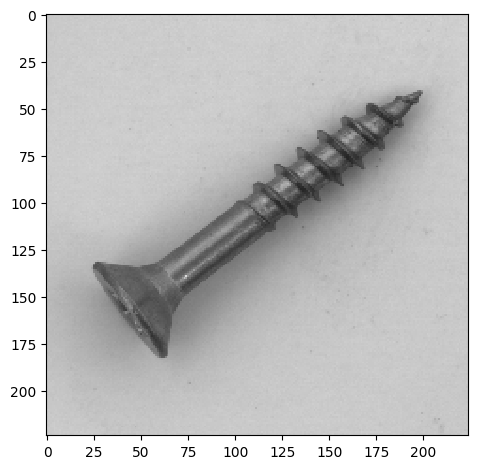

In [6]:
x, y = train_datagen[0]
io.imshow(x[0])
io.show()

In [6]:
class AnomalyDetector(models.Model):

    def __init__(self, input_shape=(224, 224, 3)):
        super(AnomalyDetector, self).__init__()

        self.encoder = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
            layers.MaxPooling2D((2, 2), strides=2),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), strides=2),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), strides=2),
            layers.Flatten()
        ])

        self.decoder = models.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(input_shape[-1], activation='sigmoid')
        ])

    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def main():
    dataset = CustomDataGen(batch_size=4, input_size=(224, 224))
    model = AnomalyDetector((224, 224, 3))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    model.fit(dataset, epochs=10)

if __name__ == '__main__':
    main()

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/mean_squared_error/BroadcastGradientArgs' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/i4624/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/i4624/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/i4624/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 728, in start
      self.io_loop.start()
    File "/home/i4624/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/i4624/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/home/i4624/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/home/i4624/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/home/i4624/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/home/i4624/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/i4624/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/i4624/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/i4624/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/i4624/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/i4624/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/i4624/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/i4624/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_31559/1947730766.py", line 36, in <module>
      main()
    File "/tmp/ipykernel_31559/1947730766.py", line 33, in main
      model.fit(dataset, epochs=10)
    File "/home/i4624/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/i4624/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/i4624/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/home/i4624/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/i4624/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/home/i4624/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1084, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/i4624/.local/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 543, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "/home/i4624/.local/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/mean_squared_error/BroadcastGradientArgs'
Incompatible shapes: [4,3] vs. [4,224,224,3]
	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1985]

In [7]:
input_model_filepath =  tf.keras.applications.VGG19( include_top=True, weights="imagenet", input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation="softmax", )
output_model_filepath = "./anomaly-segmentation-model.h5"
#model class

class AnomalySegmentator(tf.keras.Model):
    def __init__(self, init_layer = 0, end_layer = None):
        super(AnomalySegmentator, self).__init__()
        #self.L2_weight = 1e-6
        self.init_layer = init_layer
        self.end_layer = end_layer
        
    def build_autoencoder(self, c0, cd):
        self.autoencoder = Sequential([
            layers.InputLayer((self.map_shape[0]//4, self.map_shape[1]//4, c0)),
            layers.Conv2D((c0 + cd) // 2,(1,1), padding='same', activation = tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.Conv2D(2*cd,(1,1), padding='same', activation = tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.Conv2D(cd,(1,1), padding='same'),
            layers.Conv2D(2*cd,(1,1), padding='same', activation = tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.Conv2D((c0 + cd) // 2,(1,1), padding='same', activation = tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.Conv2D(c0,(1,1), padding='same')            
            
        ])
        
    def build(self, input_shape):
        
        self.vgg = VGG19(include_top = False, weights = 'imagenet', input_shape=input_shape[1:])
        self.features_list = [layer.output for layer in self.vgg.layers if 'conv' in layer.name][self.init_layer:self.end_layer]
        
        self.feature_extractor = Model(inputs = self.vgg.input, 
                                       outputs = self.features_list)
        self.feature_extractor.trainable = False   
        
        self.threshold = tf.Variable(0, trainable = False, dtype = tf.float32)

        self.map_shape = self.features_list[0].shape[1:-1]
        
        self.average_pooling = layers.AveragePooling2D(pool_size=(4, 4), strides=(4,4))       
        
        
        
        self.c0 = sum([feature.shape[-1] for feature in self.features_list])        
        self.cd = 40        
        self.build_autoencoder(self.c0, self.cd)
        
          
    def call(self, inputs):
        features = self.feature_extractor(inputs)
        resized_features = [tf.image.resize(feature, self.map_shape) for feature in features]
        resized_features = tf.concat(resized_features, axis = -1)
        
        resized_features = self.average_pooling(resized_features)

        autoencoder_output = self.autoencoder(resized_features)
        return tf.reduce_sum((autoencoder_output - resized_features)**2, axis = -1)
        
    def reconstruction_loss(self):
        @tf.function
        def _loss(y_true, y_pred):
            loss = tf.reduce_mean(y_pred, axis = (1,2)) / (tf.cast(tf.shape(y_pred)[0], tf.float32) * self.c0)
            return loss
                    
        return _loss

    def compute_threshold(self, data_loader, fpr = 0.05):
      error = []
      for i in tqdm(range(len(data_loader))):
        x, y = data_loader[i]
        error.append(self(x))

      threshold = np.percentile(error, 100 - fpr)
      self.threshold = tf.Variable(threshold, trainable = False, dtype = tf.float32)
        
    def compute_pca(self, data_loader):
        extraction_per_sample = 20
        
        extractions = []        
        for i in tqdm(range(len(data_loader))):
            x, _ = data_loader[i]     
            
            features = self.feature_extractor(x)
            resized_features = [tf.image.resize(feature, self.map_shape) for feature in features]
            resized_features = tf.concat(resized_features, axis = -1)

            resized_features = self.average_pooling(resized_features)
            
            for feature in resized_features:
                
                for _ in range(extraction_per_sample):                    
                
                    row, col = randrange(feature.shape[0]), randrange(feature.shape[1])
                    extraction = feature[row, col]
                    extractions.append(extraction)
            
        extractions = np.array(extractions)
        print(f"Extractions Shape: {extractions.shape}")
        pca = PCA(0.9, svd_solver = "full")
        pca.fit(extractions)
        self.cd = pca.n_components_
        self.build_autoencoder(self.c0, self.cd)
        print(f"Components with explainable variance 0.9 -> {self.cd}")
        
as_model = AnomalySegmentator()
as_model.compile(Adam(1e-4), loss = as_model.reconstruction_loss())

In [8]:
as_model.build((None, *INPUT_SIZE,3))
as_model.compute_pca(train_datagen)

  0%|          | 0/64 [00:00<?, ?it/s]

: 

: 

In [5]:
!bazel build -c opt --copt=-mavx --copt=-msse4.1 --copt=-msse4.2  -k //tensorflow/tools/pip_package:build_pip_package
# Create the wheel like so:
%bazel-bin/tensorflow/tools/pip_package/build_pip_package /tmp/tensorflow_pkg
# Inside your conda env:
%pip install /tmp/tensorflow_pkg/NAME_OF_WHEEL.whl

ERROR: The 'build' command is only supported from within a workspace (below a directory having a WORKSPACE file).
See documentation at https://docs.bazel.build/versions/master/build-ref.html#workspace


UsageError: Line magic function `%bazel-bin/tensorflow/tools/pip_package/build_pip_package` not found.
